In [17]:
# TODO: MOST IMPORTANT!!!!! audit data
# todo: CDD & HDD, decide about what to do about outliers if anything,
# todo: housekeeping. get rid of obsolete data and files
# todo: Modelling: SARIMA, Prophet, LSTM, 
# todo: Metrics, MAE, RMSE, 

# plots for train error and test error

# question: do we have all the temperature index is consistent. Temp is missing values for certain months and we're trying to merge on it

# question: 

In [18]:
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot
import os
import matplotlib.pyplot as plt
import plotly.express as px
import functools
import seaborn as sns
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa
import statsmodels.api as sm
import statsmodels.formula.api as smf
from config import CFG
from utils import csv_to_parquet

In [19]:
CFG = CFG()
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

# preprocess data

In [20]:
csv_to_parquet(
    csv_folder=CFG.data_path, 
    parquet_folder=CFG.data_path
)

Parquet file for forecastdemand_nsw.csv exists. Skipping conversion...
Parquet file for temperature_nsw.csv exists. Skipping conversion...
Parquet file for totaldemand_nsw.csv exists. Skipping conversion...
Parquet file for price_cleaned_data.csv exists. Skipping conversion...


# load data

In [21]:
nsw_forecastdemand = pd.read_parquet(
    os.path.join(CFG.data_path, 'forecastdemand_nsw.parquet'),
).groupby('DATETIME').agg({'FORECASTDEMAND': 'mean'})

- we should try to understand what `periodid` represents
- for now we will `groupby` datetime and use `mean()` as the agg function

In [22]:
nsw_totaldemand = pd.read_parquet(
    os.path.join(CFG.data_path, 'totaldemand_nsw.parquet'),
)

In [23]:
nsw_temperature = pd.read_parquet(
    os.path.join(CFG.data_path, 'temperature_nsw.parquet'),
).resample('30min').mean()

# checks

In [24]:
nsw_temperature.isna().sum()
# todo: need to find the time stamps for when the NAs occur

TEMPERATURE    559
dtype: int64

In [25]:
nsw_temperature[nsw_temperature.isna()]
# todo: this seems right but the return doesn't

,TEMPERATURE
DATETIME,
2010-01-01 00:00:00,NaN
2010-01-01 00:30:00,NaN
2010-01-01 01:00:00,NaN
2010-01-01 01:30:00,NaN
2010-01-01 02:00:00,NaN
...,...
2021-03-17 22:00:00,NaN
2021-03-17 22:30:00,NaN
2021-03-17 23:00:00,NaN


In [26]:
type(nsw_temperature.index)

pandas.core.indexes.datetimes.DatetimeIndex

# Price data

In [27]:
price_df = pd.read_parquet(
    os.path.join(CFG.data_path, 'price_cleaned_data.parquet'), 
)  # fix_me

In [28]:
price_df

,rrp
date,
2010-01-01 00:30:00,21.500000
2010-01-01 01:00:00,20.980000
2010-01-01 01:30:00,20.060000
2010-01-01 02:00:00,17.930000
2010-01-01 02:30:00,17.430000
...,...
2023-12-31 22:00:00,53.835000
2023-12-31 22:30:00,57.460000
2023-12-31 23:00:00,57.371667


# merge

In [29]:
dfs = [nsw_totaldemand, nsw_forecastdemand, nsw_temperature, price_df]

In [30]:
nsw_df = functools.reduce(
    lambda left, right: 
    pd.merge(
        left, 
        right, 
        left_index=True, 
        right_index=True, 
        how='inner'
    ), dfs
)

In [32]:
nsw_df['TEMPERATURE'].isna().sum()
# todo: what function shows what index?

559

# EDA

In [33]:
nsw_df.describe()

,TOTALDEMAND,FORECASTDEMAND,TEMPERATURE,rrp
count,196512.000000,196512.000000,195953.000000,195168.000000
mean,8113.146242,8107.153035,17.526475,56.939819
std,1299.536070,1303.190137,5.880189,158.741166
min,5074.630000,4878.596667,-1.300000,-264.310000
25%,7150.067500,7129.623620,13.500000,31.350000
50%,8053.230000,8061.563409,17.900000,47.680000
75%,8958.550000,8965.041462,21.500000,64.200000
max,14579.860000,14601.171964,44.700000,14700.000000


In [34]:
nsw_df.corr()

,TOTALDEMAND,FORECASTDEMAND,TEMPERATURE,rrp
TOTALDEMAND,1.000000,0.987169,0.149000,0.122732
FORECASTDEMAND,0.987169,1.000000,0.144866,0.114543
TEMPERATURE,0.149000,0.144866,1.000000,0.057326
rrp,0.122732,0.114543,0.057326,1.000000


<Axes: >

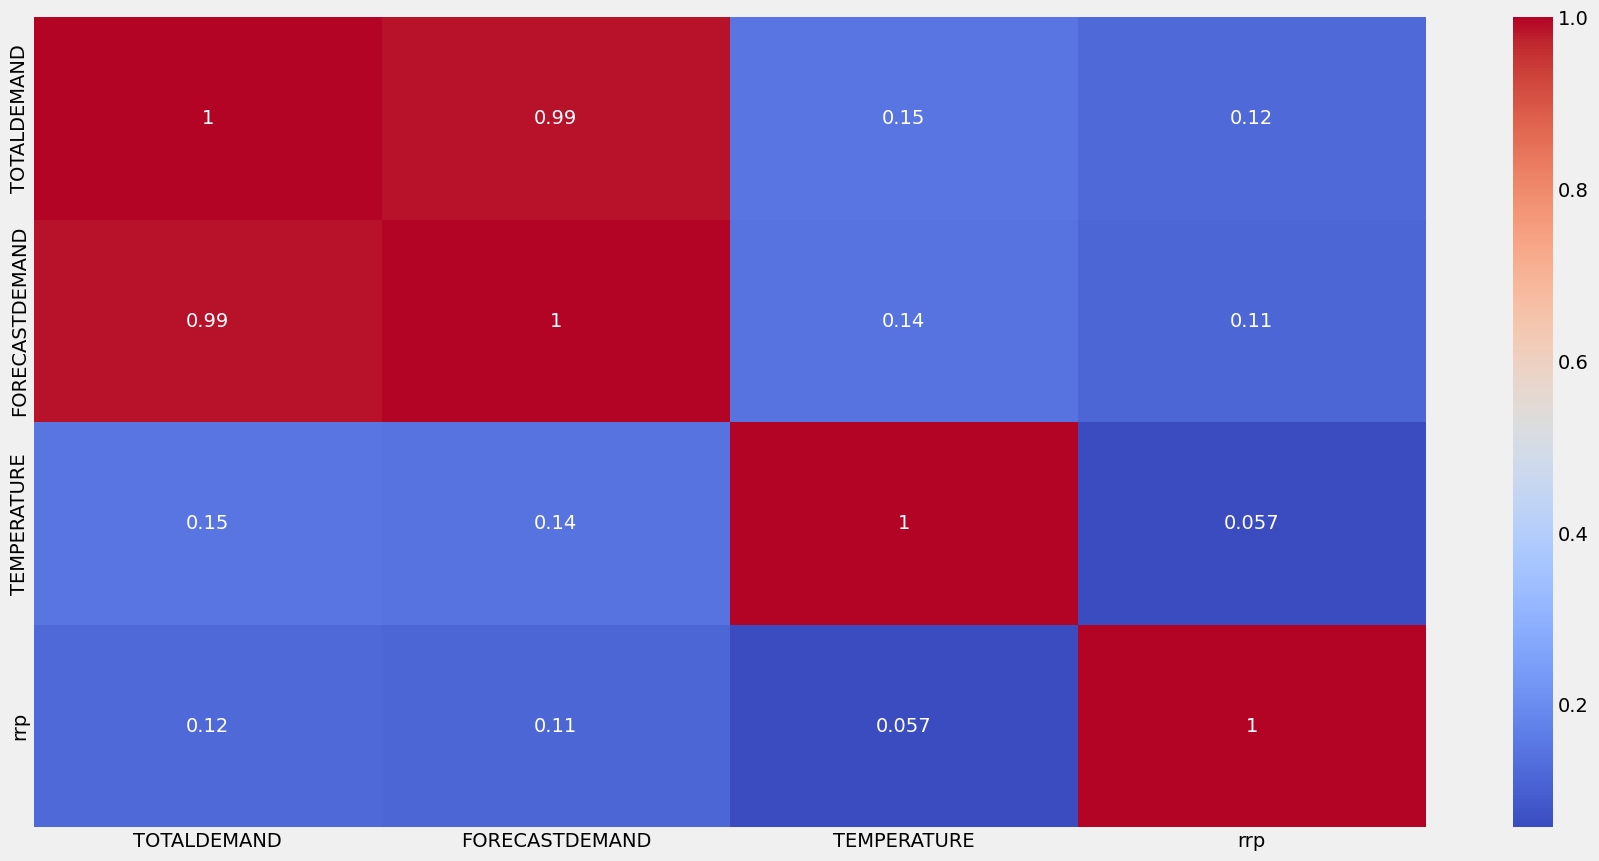

In [35]:
sns.heatmap(nsw_df.corr(), annot=True, cmap='coolwarm')

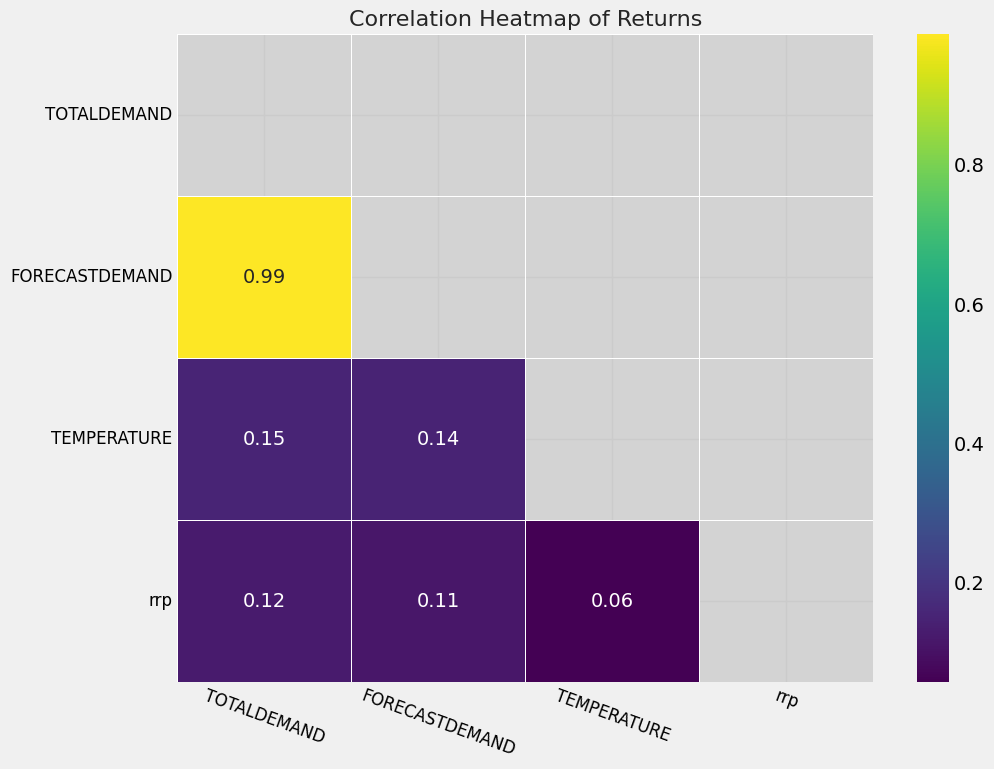

In [36]:
from utils import plot_correlation_heatmap ### also imports plot settings for the whole script
plot_correlation_heatmap(nsw_df)

# Forecast and actual demand over time

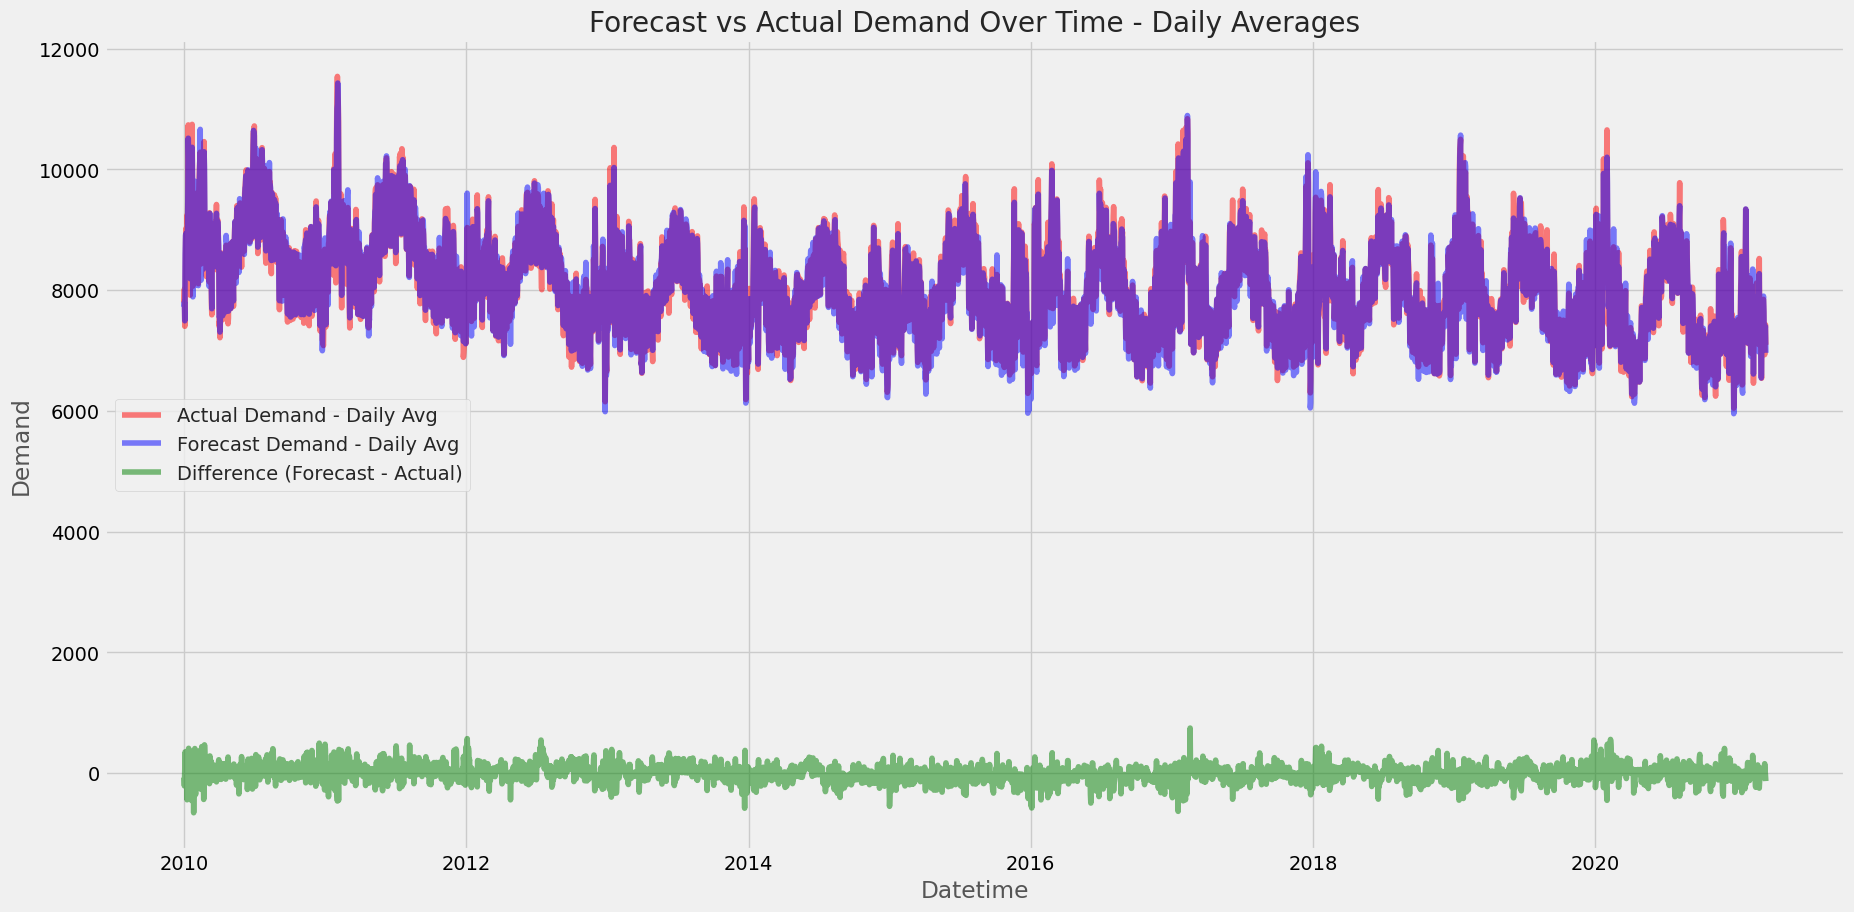

In [37]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

daily_avg_actual = nsw_df['TOTALDEMAND'].resample('D').mean()
daily_avg_forecast = nsw_df['FORECASTDEMAND'].resample('D').mean()

plt.plot(
    daily_avg_actual.index, 
    daily_avg_actual, 
    label='Actual Demand - Daily Avg', 
    color='red', 
    alpha=0.5
)

plt.plot(
    daily_avg_forecast.index, 
    daily_avg_forecast, 
    label='Forecast Demand - Daily Avg', 
    color='blue', 
    alpha=0.5
)

plt.plot(
    daily_avg_forecast.index, 
    daily_avg_forecast - daily_avg_actual, 
    label='Difference (Forecast - Actual)', 
    color='green', 
    alpha=0.5
)

plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast vs Actual Demand Over Time - Daily Averages')
plt.legend()
plt.show()

# fix_me: add a time slider to zoom in, append the daily averaged and error to the df 

In [38]:
# daily_avg_actual

In [39]:
daily_avg_actual_reindexed = daily_avg_actual.reindex(nsw_df.index)
daily_avg_actual_filled = daily_avg_actual_reindexed.bfill()
nsw_df['daily_avg_actual'] = daily_avg_actual_filled
# nsw_df['daily_avg_actual']

## backfill daily average reindexed

In [40]:
daily_avg_forecast_reindexed = daily_avg_forecast.reindex(nsw_df.index)
daily_avg_forecast_filled = daily_avg_forecast_reindexed.bfill()
nsw_df['daily_avg_forecast'] = daily_avg_forecast_filled
# nsw_df['daily_avg_forecast']

# calculate average error

In [41]:
daily_avg_error = daily_avg_forecast - daily_avg_actual
daily_avg_error_reindexed = daily_avg_error.reindex(nsw_df.index)
daily_avg_error_filled = daily_avg_error_reindexed.bfill()
nsw_df['forecast_error'] = daily_avg_error_filled
# nsw_df['forecast_error']
# todo: definition of accuracy - MSE, RMSE, MAPE, MAE

In [42]:
nsw_df

,TOTALDEMAND,FORECASTDEMAND,TEMPERATURE,rrp,daily_avg_actual,daily_avg_forecast,forecast_error
2010-01-01 00:30:00,7809.31,7680.510417,22.80,21.50,8017.459792,7804.668591,-212.791200
2010-01-01 01:00:00,7483.69,7428.971370,22.60,20.98,8017.459792,7804.668591,-212.791200
2010-01-01 01:30:00,7117.23,7084.802162,22.50,20.06,8017.459792,7804.668591,-212.791200
2010-01-01 02:00:00,6812.03,6751.369600,22.50,17.93,8017.459792,7804.668591,-212.791200
2010-01-01 02:30:00,6544.33,6484.270789,22.40,17.43,8017.459792,7804.668591,-212.791200
...,...,...,...,...,...,...,...
2021-03-17 22:00:00,7419.77,7317.702687,19.70,32.00,7094.510000,6961.076901,-133.433099
2021-03-17 22:30:00,7417.91,7266.887647,19.50,37.01,7094.510000,6961.076901,-133.433099
2021-03-17 23:00:00,7287.32,7173.866522,19.05,34.49,7094.510000,6961.076901,-133.433099
2021-03-17 23:30:00,7172.39,7043.236857,18.80,32.55,7094.510000,6961.076901,-133.433099


# Forecast Demand over time
I've made some changes to try to improve this plot:
- **Smoothing**: The plot is quite noisy, so applying a rolling mean (moving average) can help to smooth out short-term fluctuations and highlight longer-term trends.
- **Highlighting Peaks and Troughs**: You could programmatically identify and annotate significant peaks and troughs to draw attention to them.
- **Resampling**: If the data is too dense, consider resampling it to a larger time frame, such as daily or weekly averages.

In [43]:
rolling_window = 48
nsw_df['smoothed_forecast_demand'] = nsw_df['FORECASTDEMAND'].rolling(window=rolling_window).mean()
index_range = nsw_df.index[:rolling_window]
nsw_df.loc[index_range, 'smoothed_forecast_demand'] = nsw_df['smoothed_forecast_demand'][rolling_window:].bfill().head(rolling_window)

In [44]:
# calculate the index of the 50th entry
fifty_index = nsw_df.head(50).index[-1]

In [45]:
# perform backfill on the first 50 entries
nsw_df.loc[:fifty_index, 'smoothed_forecast_demand'] = nsw_df.loc[:fifty_index, 'smoothed_forecast_demand'].bfill()

In [46]:
nsw_df_daily = nsw_df['FORECASTDEMAND'].resample('D').mean()
# nsw_df_daily  # daily average forecast demand

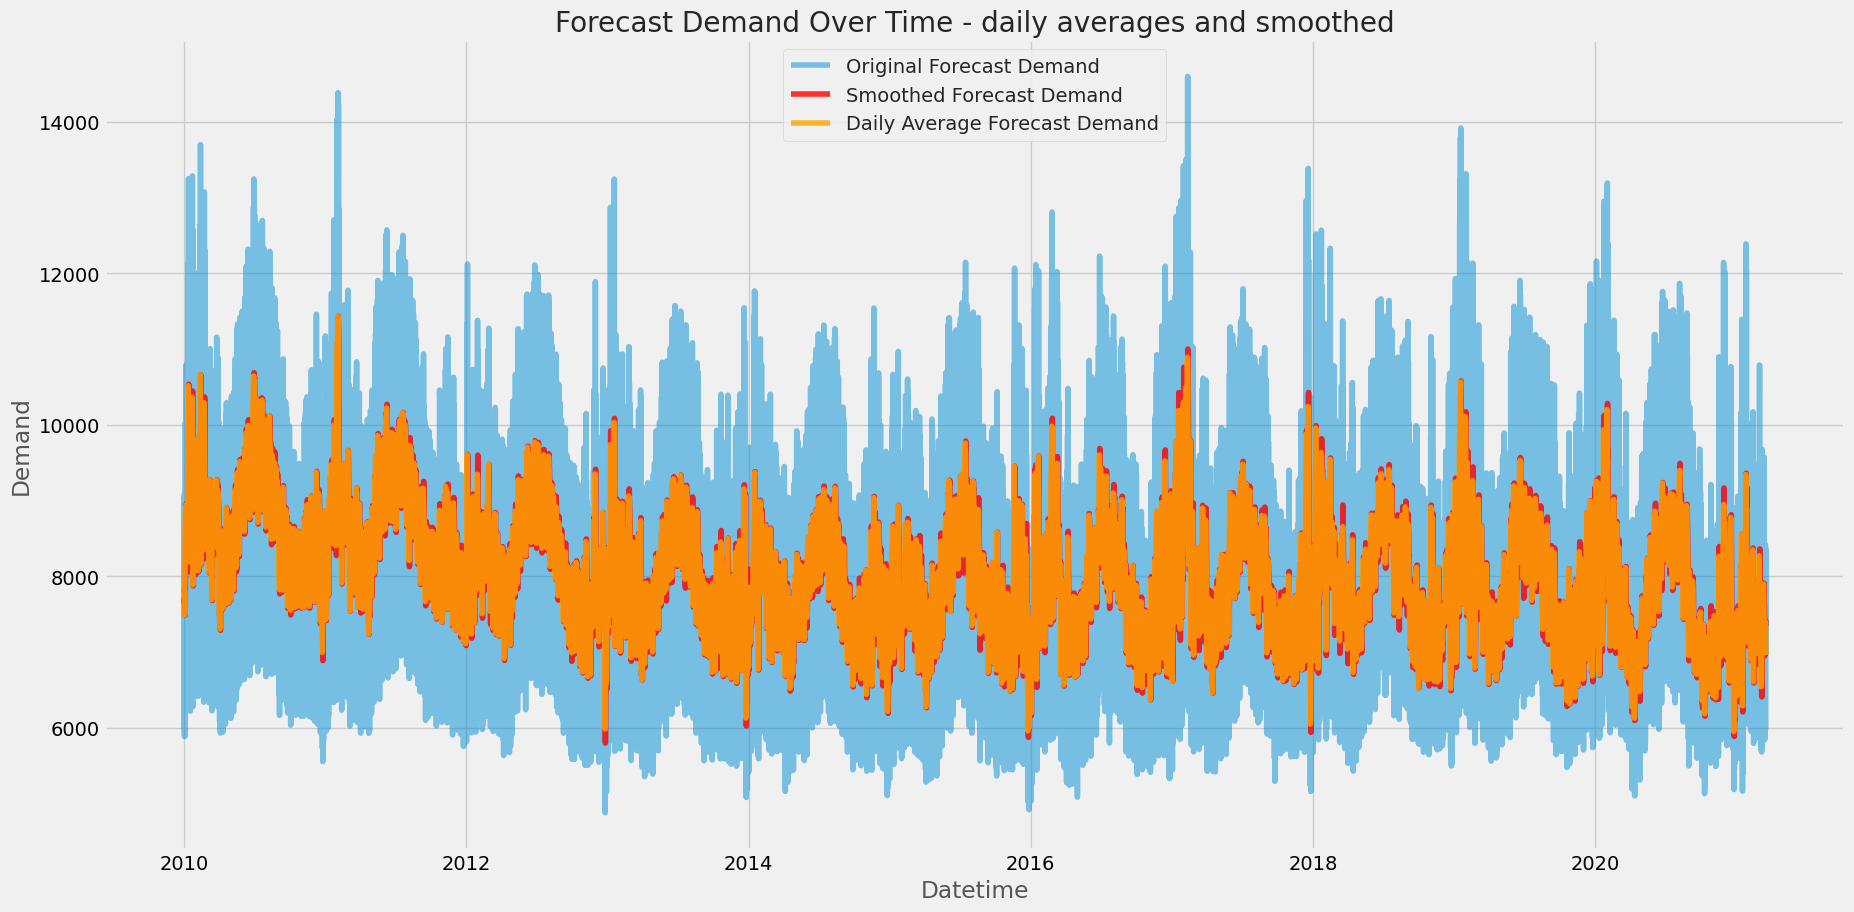

In [47]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

plt.plot(
    nsw_df['FORECASTDEMAND'], 
    label='Original Forecast Demand', 
    alpha=0.5
)

# 
plt.plot(
    nsw_df['smoothed_forecast_demand'], 
    label='Smoothed Forecast Demand', 
    color='red', 
    alpha=0.8
)

# 
plt.plot(
    nsw_df_daily.index, 
    nsw_df_daily, 
    label='Daily Average Forecast Demand', 
    color='orange', 
    alpha=0.8
)

plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast Demand Over Time - daily averages and smoothed')
plt.grid(True)
plt.legend()
plt.show()

In [48]:
nsw_df

,TOTALDEMAND,FORECASTDEMAND,TEMPERATURE,rrp,daily_avg_actual,daily_avg_forecast,forecast_error,smoothed_forecast_demand
2010-01-01 00:30:00,7809.31,7680.510417,22.80,21.50,8017.459792,7804.668591,-212.791200,7699.974365
2010-01-01 01:00:00,7483.69,7428.971370,22.60,20.98,8017.459792,7804.668591,-212.791200,7699.974365
2010-01-01 01:30:00,7117.23,7084.802162,22.50,20.06,8017.459792,7804.668591,-212.791200,7699.974365
2010-01-01 02:00:00,6812.03,6751.369600,22.50,17.93,8017.459792,7804.668591,-212.791200,7699.974365
2010-01-01 02:30:00,6544.33,6484.270789,22.40,17.43,8017.459792,7804.668591,-212.791200,7699.974365
...,...,...,...,...,...,...,...,...
2021-03-17 22:00:00,7419.77,7317.702687,19.70,32.00,7094.510000,6961.076901,-133.433099,7400.366626
2021-03-17 22:30:00,7417.91,7266.887647,19.50,37.01,7094.510000,6961.076901,-133.433099,7399.723912
2021-03-17 23:00:00,7287.32,7173.866522,19.05,34.49,7094.510000,6961.076901,-133.433099,7399.132502
2021-03-17 23:30:00,7172.39,7043.236857,18.80,32.55,7094.510000,6961.076901,-133.433099,7398.573481


In [49]:
demand = nsw_df.copy()
demand = demand[['TOTALDEMAND']]
demand.loc[:, 'dow'] = demand.index.dayofweek
demand.loc[:, 'doy'] = demand.index.dayofyear
demand.loc[:, 'year'] = demand.index.year
demand.loc[:, 'month'] = demand.index.month
demand.loc[:, 'quarter'] = demand.index.quarter
demand.loc[:, 'hour'] = demand.index.hour

nsw_df = pd.merge(nsw_df, demand, left_index=True, right_index=True)

nsw_df['season'] = nsw_df['month'].apply(lambda month: 1 if month in [12, 1, 2] else
                                  (2 if month in [3, 4, 5] else
                                  (3 if month in [6, 7, 8] else
                                  (4 if month in [9, 10, 11] else None))))

In [50]:
nsw_df

,TOTALDEMAND_x,FORECASTDEMAND,TEMPERATURE,rrp,daily_avg_actual,daily_avg_forecast,forecast_error,smoothed_forecast_demand,TOTALDEMAND_y,dow,doy,year,month,quarter,hour,season
2010-01-01 00:30:00,7809.31,7680.510417,22.80,21.50,8017.459792,7804.668591,-212.791200,7699.974365,7809.31,4,1,2010,1,1,0,1
2010-01-01 01:00:00,7483.69,7428.971370,22.60,20.98,8017.459792,7804.668591,-212.791200,7699.974365,7483.69,4,1,2010,1,1,1,1
2010-01-01 01:30:00,7117.23,7084.802162,22.50,20.06,8017.459792,7804.668591,-212.791200,7699.974365,7117.23,4,1,2010,1,1,1,1
2010-01-01 02:00:00,6812.03,6751.369600,22.50,17.93,8017.459792,7804.668591,-212.791200,7699.974365,6812.03,4,1,2010,1,1,2,1
2010-01-01 02:30:00,6544.33,6484.270789,22.40,17.43,8017.459792,7804.668591,-212.791200,7699.974365,6544.33,4,1,2010,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17 22:00:00,7419.77,7317.702687,19.70,32.00,7094.510000,6961.076901,-133.433099,7400.366626,7419.77,2,76,2021,3,1,22,2
2021-03-17 22:30:00,7417.91,7266.887647,19.50,37.01,7094.510000,6961.076901,-133.433099,7399.723912,7417.91,2,76,2021,3,1,22,2
2021-03-17 23:00:00,7287.32,7173.866522,19.05,34.49,7094.510000,6961.076901,-133.433099,7399.132502,7287.32,2,76,2021,3,1,23,2
2021-03-17 23:30:00,7172.39,7043.236857,18.80,32.55,7094.510000,6961.076901,-133.433099,7398.573481,7172.39,2,76,2021,3,1,23,2


## Observations
The plot layers three time series: 
- the original forecast demand, 
- the smoothed forecast demand, 
- and the daily average forecast demand. 

Here are some potential conclusions and observations I draw from this plot:

1. **Volatility**: The original forecast demand shows significant volatility, as indicated by the frequent and sometimes sharp peaks and valleys.

2. **Smoothing Effect**: The smoothed forecast demand (the line in red) has reduced the short-term fluctuations, making the underlying trends more visible. It appears to follow the central tendency of the original forecast, reducing the impact of extreme values.

3. **Daily Patterns**: The daily average forecast demand (the line in yellow) simplifies the data to show the trend within each day, abstracting away the half-hourly variations. This line highlights the overall daily movement in demand without the noise of intra-day fluctuations.

4. **Long-term Trends**: Despite the daily and smoothed variations, there seems to be a consistent pattern that repeats over a longer cycle, perhaps weekly or seasonally, which would be worth investigating further.

5. **Comparative Analysis**: By overlaying the smoothed and daily averaged data over the original forecast demand, it's possible to compare short-term variations to longer-term patterns. This can be crucial for understanding both normal daily operations and the impact of specific events or anomalies.

6. **Anomaly Identification**: The points where the original demand significantly diverges from its smoothed or daily average counterpart may indicate anomalies or special events that caused unusual demand (such as holidays, heatwaves, etc.).

For further analysis, I should investigate the causes of the peaks and troughs in more detail, especially the outliers. For example, examining corresponding temperature data, special events, or other external factors could provide insights into why demand might spike or dip at various points in time.

# Total Demand over time

In [51]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

nsw_df_daily = nsw_df['TOTALDEMAND'].resample('D').mean()
rolling_window = 48
nsw_df['smoothed_total_demand'] = nsw_df['TOTALDEMAND'].rolling(window=rolling_window).mean()

plt.plot(
    nsw_df['TOTALDEMAND'], 
    label='Actual Demand', 
    color='red', 
    alpha=0.3
)

plt.plot(
    nsw_df.index, 
    nsw_df['smoothed_total_demand'], 
    label='Smoothed Actual Demand', 
    color='blue', 
    alpha=0.7
)

plt.plot(
    nsw_df_daily.index, 
    nsw_df_daily, 
    label='Daily Average Demand', 
    color='yellow', 
    alpha=1.0, 
    linewidth=2
)

plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Actual Demand Over Time - Daily Averages and Smoothed')

plt.grid(True)
plt.legend()
plt.show()

KeyError: 'TOTALDEMAND'

<Figure size 2000x1000 with 0 Axes>

## Observations
This plot, which shows actual demand over time along with its daily average and smoothed version, include:

1. **Cyclical Patterns**: There are visible patterns that repeat over time, which may correspond to weekly, monthly, or seasonal cycles in electricity demand.

2. **Daily Variations**: The daily average demand (in yellow) shows how demand fluctuates on a day-to-day basis. This line smooths out the intraday variations and reveals the general movement of demand throughout the dataset's timeline.

3. **Trend Indication**: The smoothed actual demand (in blue) helps to identify the underlying trend by minimizing the impact of short-term fluctuations. This can provide insights into longer-term movements in demand, such as gradual increases or decreases over the years.

4. **Peak Demand Periods**: There are significant spikes in actual demand (in red) that stand out above the smoothed and daily average trends. These peaks could indicate days of particularly high demand, which could be due to extreme weather, special events, or other factors.

5. **Volatility**: The red peaks suggest periods of high volatility in actual demand. Understanding the factors contributing to this volatility could be crucial for grid management and planning.

6. **Data Density**: The plot is dense and hard to interpret in detail, particularly over such a long timeframe. A more granular view (e.g., looking at shorter periods) is likely provide more actionable insights. This should be the next task for me

7. **Anomalies and Outliers**: The actual demand has several outliers which are significantly different from the smoothed trend and daily average. These could represent data anomalies that may need to be investigated further.

To better understand the demand patterns and to make informed decisions, I should segment the data into different periods (such as by year, season, week and day), and analyse it in conjunction with other relevant data (like temperature or economic activity).

# Temperature over time

In [ ]:
rolling_window = 48  # this should be changed. 48 represents 24 hours
# todo: kalman filter doesn't need us to specify threshold, so its less arbitrary 
nsw_df['smoothed_temperature'] = nsw_df['TEMPERATURE'].rolling(window=rolling_window).mean()

plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

# original temperature
plt.plot(
    nsw_df.index, 
    nsw_df['TEMPERATURE'], 
    color='orange', 
    alpha=0.5, 
    label='Original Temperature'
)

# smoothed temperature
plt.plot(
    nsw_df.index, 
    nsw_df['smoothed_temperature'], 
    color='red', 
    label='Smoothed Temperature'
)

plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time with Smoothed Curve')
plt.legend()
plt.show()

## Observations
- tbc

# Scatter Plot: Temperature vs Demand
- to see if higher or lower temperatures correlate with higher or lower demand
- it looks like the line of best fit is quadratic to me

In [ ]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

# temperature vs total demand
sns.scatterplot(
    x='TEMPERATURE', 
    y='TOTALDEMAND', 
    data=nsw_df, 
    alpha=0.3
)

# fit and plot a polynomial regression with order 2 (quadratic)
sns.regplot(
    x='TEMPERATURE', 
    y='TOTALDEMAND', 
    data=nsw_df, 
    order=2, 
    scatter=False, 
    color='red'
)

plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Total Demand (MW)', fontsize=12)
plt.title('Total Demand vs. Temperature', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
# fix_me: add a color gradient to show the temperature

## Observations
The scatter plot shows Total Demand plotted against Temperature, with a quadratic trend line indicating the general pattern of the relationship between these two variables. Here are some observations we can infer from this plot:

1. **Non-linear Relationship**: There appears to be a non-linear, possibly quadratic relationship between temperature and total demand. Demand increases with temperature up to a certain point, after which it seems to plateau or even decline slightly.

2. **Increased Demand at Moderate Temperatures**: The highest total demand occurs at moderate temperatures, not at the extremes. This could indicate that the most energy-intensive activities (like heating and cooling) occur in a moderate temperature range.

3. **Lower Demand at Temperature Extremes**: There is a spread of demand at lower and higher temperatures, but the peaks are not as pronounced as in the moderate range. At low temperatures, this might mean adequate insulation or less need for electric heating. At high temperatures, it could imply that not all cooling is electric, or there may be a cap on how much cooling can be achieved.

4. **Possible Threshold Effect**: The trend line suggests that after a certain temperature threshold, increases in temperature do not result in significant increases in demand. This could be due to behavioral changes, energy-efficiency measures, or the saturation of cooling systems.

5. **Data Spread**: The considerable spread of data points at all temperature levels suggests that factors other than temperature also significantly influence total demand.

6. **High Variability**: There's significant variability in demand at specific temperatures, indicated by the vertical spread of points. This could be due to time-of-day effects, different days of the week, or other variables not accounted for in this two-dimensional plot.

# Scatter plot: Total demand vs time of day (temp as color)
To visualize demand patterns at different times of the day.

In [ ]:
# new feature
nsw_df['minutes_past_midnight'] = nsw_df.index.hour * 60 + nsw_df.index.minute

In [ ]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

# temperature, time and total demand
plt.scatter(
    nsw_df['minutes_past_midnight'], 
    nsw_df['TOTALDEMAND'], 
    c=nsw_df['TEMPERATURE'], 
    alpha=0.6, 
    cmap='coolwarm', 
    s=20
)  

plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Total Demand (MW)', fontsize=12)
plt.title('Total Demand vs. Time of Day', fontsize=14)
plt.grid(True)
tick_positions = range(0, 1441, 60)
tick_labels = [f'{h:02d}:00' for h in range(24)] + ['00:00']
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.tight_layout()
plt.show()

## Observations
1. **Demand Peaks**: It appears that there are two distinct peaks in electricity demand, likely corresponding to morning and evening hours. This is a common pattern in electricity usage, often related to increased activity as people prepare for work and school, and then again as they come home and use more appliances.

2. **Temperature Influence**: The color gradient indicates a relationship between temperature and total demand. Warmer colors at higher demand levels could suggest higher energy usage during warmer temperatures, which might be due to air conditioning and cooling systems.

3. **Cooler Temperatures**: At cooler temperatures (blue points), demand seems less intense compared to warmer temperatures, which might indicate less energy usage for heating compared to cooling, or it could suggest that the data is from a region where cooling needs are greater than heating needs.

4. **Demand Troughs**: There are clear periods where demand is lower, likely during the night when most activities cease, and there's little need for lighting and appliances.

5. **Midday Patterns**: There's a visible increase in demand around midday, which could be due to usage in commercial buildings or by industrial processes.

6. **Temperature Variability**: There's a spread of temperature values across all times, but particularly so during the times of peak demand. This suggests that on days with higher temperatures, the peaks in demand might be more pronounced.

7. **Intraday Variability**: There's significant variability in demand at any given time, which could be influenced by various factors including but not limited to temperature, such as the day of the week, holidays, or specific events.

# Scatter plot: Temperature vs Total Demand vs Forecast Demand

In [ ]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

# total demand vs temperature
sns.scatterplot(
    x=nsw_df['TEMPERATURE'] + np.random.uniform(-0.15, 0.15, size=len(nsw_df)), 
    y=nsw_df['TOTALDEMAND'], 
    label='Total Demand', 
    alpha=0.6,
    s=20,
    edgecolor='none'
)

# forecast demand vs temperature
sns.scatterplot(
    x=nsw_df['TEMPERATURE'] + np.random.uniform(-0.15, 0.15, size=len(nsw_df)), 
    y=nsw_df['FORECASTDEMAND'], 
    label='Forecast Demand', 
    alpha=0.6,
    s=20,
    edgecolor='none'
)

plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Demand (MW)', fontsize=14)
plt.title('Temperature vs Demand', fontsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## Observations
The plot illustrates Total Demand and Forecast Demand as they relate to Temperature, depicted in different colours for comparison. Here’s what we can interpret from this plot:

1. **Forecast vs. Actual Demand**: Both total and forecast demand show a similar trend with temperature, suggesting the forecasting model is generally capturing the temperature-related variability in demand. However, the non-overlapping areas highlight where the forecast demand significantly deviates from the actual demand. This could occur during unexpected temperature fluctuations or when other factors influencing demand are not accounted for in the forecasting model.

2. **Spread of Forecast**: The forecast demand data points are spread across a wide range of the actual demand values, especially at mid-range temperatures. This could indicate potential inaccuracies in the forecast during those conditions, or it might reflect natural variability in demand that isn't fully captured by temperature alone.

3. **Higher Temperatures**: At higher temperatures, both total and forecast demand are elevated, which typically corresponds with increased use of cooling systems. The forecasts appear to follow this trend. However, it also looks like the model may be less accurate under extreme temperature conditions where the behavior of the demand might be less predictable or more volatile.

4. **Lower Temperatures**: Similarly, increased demand at lower temperatures is likely due to heating needs. The forecast demand also follows this trend. similar comment to high temps

5. **Concentration of Data**: There seems to be a dense concentration of data points at certain temperatures, indicating common temperature ranges for the dataset. Less dense areas also represent areas that are less accurate.

6. **Discrepancies**: There are noticeable discrepancies between forecast and actual demand at certain temperatures. Why

7. **Model Performance**: The overlay of forecast on actual demand can be used to evaluate the performance of the forecasting model across the temperature range. The closer the fit, the better the model is at capturing the impact of temperature on demand.

8. **Temperature Extremes**: Both demand values tend to be higher at the temperature extremes, suggesting a U-shaped relationship where both heating and cooling drive up energy demand.

This visual comparison is valuable for understanding how well the forecasting model performs relative to actual demand. 

# Histogram: total demand distribution
to get an idea of the most common demand levels

In [ ]:
nsw_df['TOTALDEMAND'].hist(bins=50)
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

## Histogram: temperature distribution

In [ ]:
nsw_df['TEMPERATURE'].hist(bins=50, color='orange')
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

# KDE of Total demand
to see the probability density of the total demand levels

In [ ]:
nsw_df['TOTALDEMAND'].plot(kind='kde')
plt.xlabel('Total Demand')
plt.title('KDE of Total Demand')
plt.show()

# Autocorrelation plot

In [ ]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
max_lags = 96
autocorrelation_values = [nsw_df['TOTALDEMAND'].autocorr(lag=i) for i in range(max_lags)]
plt.plot(autocorrelation_values, marker='o')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Total Demand up to lag {}'.format(max_lags))
plt.show()

## Observations
For half-hourly data, 96 lags represent a full two days. From the autocorrelation plot, we can make some key interpretations:

1. **High Initial Autocorrelation**: The autocorrelation starts at 1 (as it must, since this represents correlation with itself at lag 0) and remains high over the initial lags, which suggests that the demand data is strongly influenced by its immediate past values. This could be due to consistent patterns of demand across adjacent time intervals.

2. **Daily Seasonality**: The peak in autocorrelation at lag 48 (which represents a full day's lag for half-hourly data) indicates a strong daily seasonal pattern. The demand at the same time on one day is highly correlated with the demand at the same time on the next day.

3. **Two-Day Cycle**: The second peak at lag 96 shows that the demand also correlates with itself two days apart. This reinforces the daily seasonality and suggests a stable pattern of demand that repeats every 48 half-hour period.

4. **Troughs at Intermediate Lags**: The troughs at lags that are halfway between the peaks (around 24 and 72) may suggest a less significant correlation at these intermediate points. This could be due to the contrast between daytime and nighttime demand or the differences in demand patterns between workdays and non-workdays.

This autocorrelation structure indicates that any models for forecasting or analysis should account for daily seasonality. Time series models such as ARIMA with seasonal components or machine learning models with lagged features might be well-suited to capture and predict these patterns.

# Boxplot
I'm now using z-score normalisation instead of log transform because temperature contains zero and negative values

In [ ]:
# Apply z-score normalization
nsw_df['normalised_total_demand'] = zscore(nsw_df['TOTALDEMAND'])
nsw_df['normalised_forecast_demand'] = zscore(nsw_df['FORECASTDEMAND'])
nsw_df['normalised_temperature'] = zscore(nsw_df['TEMPERATURE'])

# Plot the box plots for the normalised values
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.boxplot(
    [
        nsw_df['normalised_total_demand'], 
        nsw_df['normalised_forecast_demand'],
        nsw_df['normalised_temperature']
    ],
    labels=['Normalised Total Demand', 'Normalised Forecast Demand', 'Normalised Temperature']
)
plt.title('Normalised Distributions of Demand and Temperature')
plt.show()

In [ ]:
nsw_df.columns

## Observations
Based on the box plot for the normalised distributions of Total Demand, Forecast Demand, and Temperature:

1. **Central Tendency**: The median of the Total Demand and Forecast Demand (indicated by the line in the middle of the box) are at or near zero, which is expected after normalization. It seems the median for Temperature is also close to zero after normalization.

2. **Variability**: The interquartile range (IQR, represented by the box) is more extended for Total Demand compared to Forecast Demand, indicating greater variability in actual demand. The IQR for Temperature appears much smaller, suggesting less variability relative to its mean.

3. **Outliers**: The presence of outliers is indicated by the points beyond the whiskers in both Total Demand and Forecast Demand. These are individual data points that lie beyond the typical range (1.5 times the IQR).

4. **Symmetry**: The distributions for both demand variables appear reasonably symmetrical around their median, though Total Demand has a notable number of high outliers.

5. **Comparison of Distributions**: The fact that both demands have similar box heights (IQRs) but Total Demand has more outliers could indicate that extreme values are more common in the actual demand than forecasted. 

6. **Temperature Distribution**: Even though the temperature is normalized, the small IQR and the presence of outliers suggest that there are times when the temperature is significantly different from the mean temperature.

# Decomposition

In [ ]:
res = seasonal_decompose(
    nsw_df['TOTALDEMAND'], 
    model='additive', 
    period=48
)
res.plot()

# Decomposition of 1 year of data

In [ ]:
one_year_data = nsw_df.loc['2020']
res_one_year = seasonal_decompose(
    one_year_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)
res_one_year.plot()

### decompose for one week

In [ ]:
one_week_data = nsw_df['2020-01-01':'2020-01-07']
res_one_week = seasonal_decompose(
    one_week_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)
res_one_week.plot()

### Decompose for 2 days

In [ ]:
one_day_data = nsw_df['2020-01-01 00:00:00': '2020-01-02 23:30:00']
res_one_day = seasonal_decompose(
    one_day_data['TOTALDEMAND'], 
    model='additive',
    period=48
)
res_one_day.plot()

In [ ]:
nsw_df

In [ ]:
nsw_df['normalised_temperature'].isna().sum()
# Fix_me: this columns is a problem

In [ ]:
nsw_df['TEMPERATURE'].isna().sum()

In [ ]:
nsw_df.isna().sum()

In [ ]:
nsw_df.columns

In [ ]:
nsw_df.dtypes

In [ ]:
nsw_df.isna().sum()

In [ ]:
# nsw_df.drop(['FORECASTDEMAND_daily', 'TOTALDEMAND_daily'], axis=1, inplace=True)

In [ ]:
# demand = nsw_df.copy()
# demand = demand[['totaldemand']]
# demand.loc[:, 'dow'] = demand.index.dayofweek
# demand.loc[:, 'doy'] = demand.index.dayofyear
# demand.loc[:, 'year'] = demand.index.year
# demand.loc[:, 'month'] = demand.index.month
# demand.loc[:, 'quarter'] = demand.index.quarter
# demand.loc[:, 'hour'] = demand.index.hour
# 
# final_df = pd.merge(nsw_df, demand, left_index=True, right_index=True)
# 
# final_df['season'] = final_df['month'].apply(lambda month: 1 if month in [12, 1, 2] else
#                                   (2 if month in [3, 4, 5] else
#                                   (3 if month in [6, 7, 8] else
#                                   (4 if month in [9, 10, 11] else None))))

In [ ]:
def Degree_Days2(df, HDD_ct=17, CDD_ct=19.5):
    Tbar = df.resample('24H', offset='21H').mean() # mean from 9pm (day i-1) - 9pm (day i)
    DD = pd.DataFrame(index=df.index, columns=['HDD', 'CDD'])
    for i in range(0,Tbar.shape[0]):
        DD['HDD'].iloc[48*(i):48*(i+1)] = max(0, HDD_ct-Tbar.iloc[i])
        DD['CDD'].iloc[48*(i):48*(i+1)] = max(0, Tbar.iloc[i]-CDD_ct)
    return Tbar, DD

In [ ]:
Degree_Days2(final_df['TEMPERATURE'])

In [ ]:
Tbar, DD = Degree_Days2(final_df['TEMPERATURE'])
# final_df['HDD'] = DD['HDD']
# final_df['CDD'] = DD['CDD']
# fix_me: this is a daily metric for now. repeat same value for each 30 min sample on that day
# fix_me: can we combine these so we don't have 0 values?

In [ ]:
plt.plot(DD.iloc[1: 10000])
plt.title("Degree Days")
plt.xlabel("Time")
plt.ylabel("Degrees °C")
plt.legend()
plt.show()
# todo: fix warnings
# todo: these are the plotted CDD and HDD vars

In [ ]:
temp_df = final_df[['TEMPERATURE', 'month', 'season']]

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=temp_df, x=temp_df.index, y='TEMPERATURE', hue='season')
plt.title('Temperature ScatterPlot')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=temp_df, x='season', y='TEMPERATURE', hue='season')
plt.show()

In [ ]:
temp_highest_allowed = round(temp_df['TEMPERATURE'].mean() + 3 * temp_df['TEMPERATURE'].std(), 2)
temp_lowest_allowed = round(temp_df['TEMPERATURE'].mean() - 3 * temp_df['TEMPERATURE'].std(), 2)
print('Highest Allowed:', temp_highest_allowed)
print('Lowest Allowed:', temp_lowest_allowed)

In [ ]:
temp_outliers = temp_df[(temp_df['TEMPERATURE'] > temp_highest_allowed) | (temp_df['TEMPERATURE'] < temp_lowest_allowed)]
print('Total Rows:', len(temp_outliers))

In [ ]:
# todo: create a separate temp column, check with if statement, cap values if outside threshold
# final_df.loc['2013-02-01']  # problem
# final_df.loc['2016-07-15']  # there is a problem from 16 - 18
# todo: somehow we need to check that that each day has 48 samples

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=temp_outliers, x=temp_outliers.index, y='TEMPERATURE', hue='season')
plt.title('Temperature Outliers ScatterPlot')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [ ]:
high_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE'] > temp_highest_allowed]
t_high_df = high_outliers['month'].value_counts()
t_high_df = t_high_df.reset_index()
t_high_df.columns = ['Month', 'Count']
t_high_df_sorted = t_high_df.sort_values(by='Month', ascending=True)
print(t_high_df_sorted)

In [ ]:
# histogram
plt.figure(figsize=(15, 10))
sns.barplot(data=t_high_df_sorted, x='Month', y='Count')
plt.title('Distribution of High Temperature Outliers')
plt.show()

In [ ]:
low_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE'] < temp_lowest_allowed]
t_low_df = low_outliers['month'].value_counts()
t_low_df = t_low_df.reset_index()
t_low_df.columns = ['Month','Count']
t_low_df_sorted = t_low_df.sort_values(by='Month', ascending=True)
print(t_low_df_sorted)

In [ ]:
# Histogram
plt.figure(figsize=(15, 10))
sns.barplot(data=t_low_df, x='Month', y='Count')
plt.title('Distribution of Low Temperature Outliers')
plt.show()

In [ ]:
price_outlier_df = final_df[['rrp', 'month', 'season']]

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=price_outlier_df, x=price_outlier_df.index, y='rrp', hue='season')
plt.title('Price ScatterPlot')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
price_highest_allowed = round(price_outlier_df['rrp'].mean() + 3 * price_outlier_df['rrp'].std(), 2)
price_lowest_allowed = round(price_outlier_df['rrp'].mean() - 3 * price_outlier_df['rrp'].std(), 2)

In [ ]:
price_outliers = price_outlier_df[(price_outlier_df['rrp']>price_highest_allowed) | (price_outlier_df['rrp']<price_lowest_allowed)]
print(len(price_outliers))

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=price_outliers,x='month', y='rrp', hue='season')
plt.title('Scatterplot of Price by Month')
plt.legend()
plt.show()

In [ ]:
# low_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE']<temp_lowest_allowed]
price_out_df = price_outliers['month'].value_counts()
price_out_df = price_out_df.reset_index()
price_out_df.columns = ['Month', 'Count']
price_out_df_sorted = price_out_df.sort_values(by='Month', ascending=True)
# print(price_out_df_sorted)

In [ ]:
# Histogram
plt.figure(figsize=(15, 10))
sns.barplot(data=price_out_df_sorted, x='Month', y='Count')
plt.title('Distribution of Price Outliers')
plt.show()

In [ ]:
total_demand_highest_allowed = round(final_df['TOTALDEMAND'].mean() + 3 * final_df['TOTALDEMAND'].std(), 2)
total_demand_lowest_allowed = round(final_df['TOTALDEMAND'].mean() - 3 * final_df['TOTALDEMAND'].std(), 2)
print(total_demand_highest_allowed)
print(total_demand_lowest_allowed)
# fix_me: we have misalignment between this and NS_test

In [ ]:
total_demand_outliers = final_df[(final_df['TOTALDEMAND'] > total_demand_highest_allowed) | (final_df['TOTALDEMAND'] < total_demand_lowest_allowed)]
print(len(total_demand_outliers))

In [52]:
plt.figure(figsize=(20, 10))
plt.scatter(
    total_demand_outliers.index, 
    total_demand_outliers['TOTALDEMAND'], 
    c=total_demand_outliers['month']
)
plt.legend()
plt.show()

NameError: name 'total_demand_outliers' is not defined

<Figure size 2000x1000 with 0 Axes>

In [53]:
print(total_demand_outliers['month'].value_counts())

NameError: name 'total_demand_outliers' is not defined

# Outlier handling

In [54]:
from sklearn.ensemble import IsolationForest

In [55]:
handle_outliers = final_df[['TEMPERATURE', 'rrp', 'TOTALDEMAND', 'month', 'season']]

NameError: name 'final_df' is not defined

In [56]:
final_df

NameError: name 'final_df' is not defined

In [57]:
random_state = np.random.RandomState(42)

model = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination=float(0.003)
)

model.fit(handle_outliers[['TEMPERATURE']])
print(model.get_params())
handle_outliers['Iso_forest_scores'] = model.decision_function(handle_outliers[['TEMPERATURE']])
handle_outliers['anomaly_score'] = model.predict(handle_outliers[['TEMPERATURE']])
handle_outliers[handle_outliers['anomaly_score'] == -1].head()
anomaly_df = handle_outliers[handle_outliers['anomaly_score'] == -1]
no_anomaly_df = handle_outliers[handle_outliers['anomaly_score'] == 1]

NameError: name 'handle_outliers' is not defined

In [58]:
anomaly_df.columns

NameError: name 'anomaly_df' is not defined

In [59]:
anomaly_df

NameError: name 'anomaly_df' is not defined

In [60]:
print('Total Anomalies:', len(anomaly_df))
print('Total non-Anomaly:', len(no_anomaly_df))
# fix_me: we have an inconsistency here

NameError: name 'anomaly_df' is not defined

In [61]:
lag_test = final_df['TEMPERATURE'].shift(2)
lag_test

NameError: name 'final_df' is not defined

In [62]:
varShifted = final_df['TEMPERATURE'].shift(2)
varShifted = varShifted.interpolate(method='linear', limit_direction='both', axis=0)
varShifted



NameError: name 'final_df' is not defined

In [63]:
from utils import KalmanFilterAverage, KalmanFilterRegression, half_life
# state_means, _ = KalmanFilterRegression(self.KalmanFilterAverage(x),
#                                     self.KalmanFilterAverage(y), delta=1e-7)
from pykalman import KalmanFilter
test = nsw_df['TOTALDEMAND']

# Smoothing the input data helps to reduce the impact of random noise in the 
# data and produce a more stable estimate of the underlying trend, 
# which can lead to more accurate and reliable estimates of the system's state.

# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01
    )
# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(test.values)
state_means = pd.Series(state_means.flatten(), index=test.index)

nsw_df['TOTALDEMAND'].plot(alpha=0.5, label='Real Demand Data')
state_means.plot(label='Kalman Smoothed')
plt.legend()

KeyError: 'TOTALDEMAND'

# Rolling & lagged statistics

# autocorrelation analysis (ACF and PACF)

In [64]:
tsa.plot_acf(nsw_df['TOTALDEMAND'])
plt.show()
# todo: what does this mean?

KeyError: 'TOTALDEMAND'

In [65]:
tsa.plot_pacf(nsw_df['TOTALDEMAND'])
plt.show()
# todo: what does this mean?

KeyError: 'TOTALDEMAND'

# Feature Engineering - Date-Time Features

In [66]:
demand = nsw_df[['TOTALDEMAND']].copy()
demand.loc[:, 'dow'] = demand.index.dayofweek
demand.loc[:, 'doy'] = demand.index.dayofyear
demand.loc[:, 'year'] = demand.index.year
demand.loc[:, 'month'] = demand.index.month
demand.loc[:, 'quarter'] = demand.index.quarter
demand.loc[:, 'hour'] = demand.index.hour
# todo: half hour
# todo: deal with the Nans, 
# todo: datetime as index
# demand.loc[:, 'weekday'] = demand.index.weekday_names  ## errors
# demand.loc[:, 'woy'] = demand.index.weekofyear  ## errors
demand.loc[:, 'dom'] = demand.index.day

KeyError: "None of [Index(['TOTALDEMAND'], dtype='object')] are in the [columns]"

In [67]:
nsw_df_dt = nsw_df.merge(demand)
nsw_df_dt  
# todo: needs more work

,TOTALDEMAND_x,FORECASTDEMAND,TEMPERATURE,rrp,daily_avg_actual,daily_avg_forecast,forecast_error,smoothed_forecast_demand,TOTALDEMAND_y,dow,doy,year,month,quarter,hour,season,TOTALDEMAND
0,7809.31,7680.510417,22.80,21.50,8017.459792,7804.668591,-212.791200,7699.974365,7809.31,4,1,2010,1,1,0,1,7809.31
1,7483.69,7428.971370,22.60,20.98,8017.459792,7804.668591,-212.791200,7699.974365,7483.69,4,1,2010,1,1,1,1,7483.69
2,7483.69,7428.971370,22.60,20.98,8017.459792,7804.668591,-212.791200,7699.974365,7483.69,4,1,2010,1,1,1,1,7117.23
3,7117.23,7084.802162,22.50,20.06,8017.459792,7804.668591,-212.791200,7699.974365,7117.23,4,1,2010,1,1,1,1,7483.69
4,7117.23,7084.802162,22.50,20.06,8017.459792,7804.668591,-212.791200,7699.974365,7117.23,4,1,2010,1,1,1,1,7117.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393017,7287.32,7173.866522,19.05,34.49,7094.510000,6961.076901,-133.433099,7399.132502,7287.32,2,76,2021,3,1,23,2,7287.32
393018,7287.32,7173.866522,19.05,34.49,7094.510000,6961.076901,-133.433099,7399.132502,7287.32,2,76,2021,3,1,23,2,7172.39
393019,7172.39,7043.236857,18.80,32.55,7094.510000,6961.076901,-133.433099,7398.573481,7172.39,2,76,2021,3,1,23,2,7287.32
393020,7172.39,7043.236857,18.80,32.55,7094.510000,6961.076901,-133.433099,7398.573481,7172.39,2,76,2021,3,1,23,2,7172.39
